# Simple 2D DIC (2 images)

Minimal example using the **refactored `d2ic` API** on one reference image and one deformed image.
It shows: mask→mesh, coarse initialization (optional), global solve (CG), optional local refinement, and plotting.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import annotations

from pathlib import Path
import sys

import logging
import os

# Silence noisy PJRT plugin init errors on environments without a working CUDA stack.
logging.getLogger('jax._src.xla_bridge').setLevel(logging.CRITICAL)

# Avoid CUDA init warnings on machines without a working GPU stack.
# on machines without a working GPU stack.
os.environ.setdefault('JAX_PLATFORMS', 'cpu')

import jax
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

jax.config.update('jax_enable_x64', True)


## 1) Load 2 images + ROI mask


repo_root: /workspaces/08_dic/D2IC
ref: ohtcfrp_00.tif (1040, 400) float64
def: ohtcfrp_10.tif (1040, 400) float64
mask: (1040, 400) bool roi_pixels= 278049


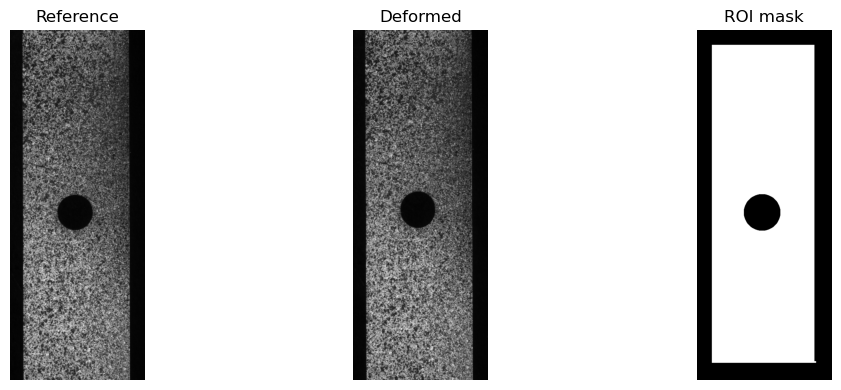

In [2]:
from d2ic import (
    InitMotionConfig,
    MeshDICConfig,
    DICInitMotion,
    DICMeshBased,
    TranslationZNCCSolver,
    GlobalCGSolver,
    LocalGaussNewtonSolver,
    mask_to_mesh_assets_gmsh,
    DICPlotter,
)
img_dir = Path('doc') / 'img' / 'PlateHole'
out_dir = Path('doc') / '_outputs' / 'simple2d_notebook'
out_dir.mkdir(parents=True, exist_ok=True)

ref_path = img_dir / 'ohtcfrp_00.tif'
def_path = img_dir / 'ohtcfrp_10.tif'

im_ref = imread(ref_path).astype(float)
im_def = imread(def_path).astype(float)

mask = imread(img_dir / 'roi.tif')
if mask.ndim == 3:
    mask = mask[..., 0]
mask = mask > 0

print('ref:', ref_path.name, im_ref.shape, im_ref.dtype)
print('def:', def_path.name, im_def.shape, im_def.dtype)
print('mask:', mask.shape, mask.dtype, 'roi_pixels=', int(mask.sum()))

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap='gray')
ax[0].set_title('Reference')
ax[1].imshow(im_def, cmap='gray')
ax[1].set_title('Deformed')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('ROI mask')
for a in ax:
    a.axis('off')
plt.tight_layout()


## 2) Build a mesh from the ROI mask (Gmsh)

We generate a quadrilateral mesh from `roi.tif` using the Gmsh-based pipeline `mask_to_mesh_assets_gmsh`.

Requirements:
- Python packages: `gmsh`, `meshio`
- System libraries for Gmsh (platform-dependent)


In [3]:
try:
    mesh, assets = mask_to_mesh_assets_gmsh(
        mask=mask,
        element_size_px=20.0,
        contour_step_px=2.0,
        remove_islands=True,
        min_island_area_px=64,
    )
except ImportError as exc:
    raise ImportError(
        'Gmsh meshing requires the `gmsh` and `meshio` Python packages. '
        'Install them (and any system deps for Gmsh), then rerun this cell.'
    ) from exc

print('nodes:', np.asarray(mesh.nodes_xy).shape)
print('elements:', np.asarray(mesh.elements).shape)



nodes: (2383, 2)
elements: (841, 4)


## 3) Configure the DIC object (`DICMeshBased`)


In [4]:
init_cfg = InitMotionConfig(win=41, search=24)
mesh_cfg = MeshDICConfig(
    max_iters=600,
    tol=1e-3,
    reg_strength=1e-4,
    strain_gauge_length=40.0,
)

dic_mesh = DICMeshBased(
    mesh=mesh,
    solver=GlobalCGSolver(interpolation='cubic'),
    config=mesh_cfg,
)
dic_mesh.prepare(im_ref, assets)


## 4) Estimate an initial displacement (optional)


In [5]:
dic_init = DICInitMotion(init_cfg, TranslationZNCCSolver(init_cfg))
dic_init.prepare(im_ref, assets)
init_res = dic_init.run(im_def)
dic_mesh.set_initial_guess(init_res.u_nodal)

u0 = np.asarray(init_res.u_nodal)
print('init guess mean [px]:', u0.mean(axis=0))


init guess mean [px]: [-0.71149151 -8.38090507]


## 5) Solve global DIC


In [6]:
result = dic_mesh.run(im_def)
u = np.asarray(result.u_nodal)
print('u_nodal:', u.shape)
print('diagnostics:', result.diagnostics.info)


u_nodal: (2383, 2)
diagnostics: {'stage': 'mesh_based', 'note': 'stage-2 placeholder', 'n_iters': 121, 'history': 'attached', 'strain': 'green_lagrange'}


## 6) Visualize the displacement field


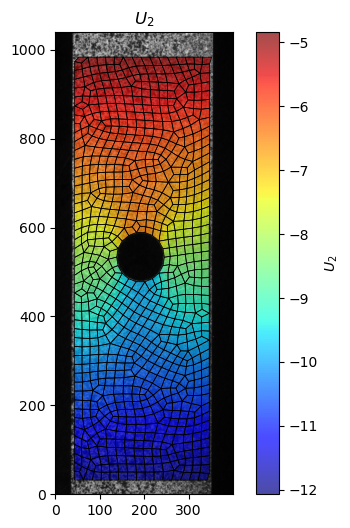

In [7]:
plotter = DICPlotter(result=result, mesh=mesh, def_image=im_def, ref_image=im_ref, project_on_deformed='fast')
fig, ax = plotter.plot('u2', image_alpha=0.7, plotmesh=True)
plt.show()

## 7) (Optional) Local refinement


In [8]:
local_cfg = MeshDICConfig(
    max_iters=10,
    tol=1e-3,
    reg_strength=1e-4,
    strain_gauge_length=40.0,
)
local_solver = LocalGaussNewtonSolver(
    lam=0.1,
    max_step=0.2,
    omega=0.5,
    interpolation='cubic',
)
dic_local = DICMeshBased(mesh=mesh, solver=local_solver, config=local_cfg)
dic_local.prepare(im_ref, assets)
dic_local.set_initial_guess(result.u_nodal)
result_refined = dic_local.run(im_def)

u_ref = np.asarray(result_refined.u_nodal)
print('refined mean [px]:', u_ref.mean(axis=0))


refined mean [px]: [-0.70324932 -8.38227927]


## 8) Plot strains (Green–Lagrange)


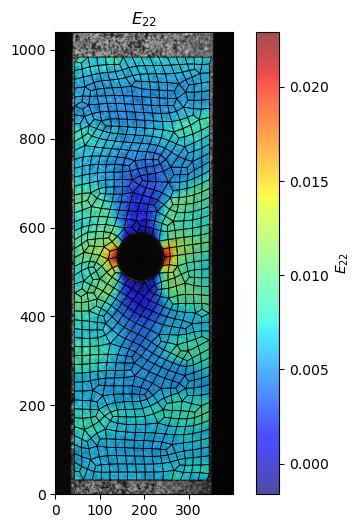

In [10]:
res_to_plot = result_refined if 'result_refined' in globals() else result
plotter_strain = DICPlotter(result=res_to_plot, mesh=mesh, def_image=im_def, ref_image=im_ref, project_on_deformed='fast')
fig, ax = plotter_strain.plot('e22', image_alpha=0.7, plotmesh=True)
plt.show()